In [1]:
import numpy as np
import copy
import random
import pandas as pd
from community_detection import *
from matplotlib import pyplot as plt
from collections import Counter
from matplotlib.patches import Patch
import textwrap

/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# merged_df = pd.read_csv('tardis_data/final_combined_2024/combined_2024_5m.csv.gz', index_col=0, parse_dates=True) #Missing about 3 coins (so far I can see its missing Bitcoin and ETH)

In [3]:
# #Drop duplicate column that came from original merged_df (ATOM was duplicated in the original data)
# merged_df = merged_df.drop(columns=['ATOMUSDT_2024_5m_x'])

# #Rename remaining Atom column
# merged_df = merged_df.rename(columns={'ATOMUSDT_2024_5m_y': 'ATOMUSDT_2024_5m'})
# merged_df.columns

In [4]:
# #Get missing coins. Only coin that is missoing now is OM
# merged_df_BTC_ETH = pd.read_csv('tardis_data/combined/combined_2024_5m.csv.gz', index_col=0, parse_dates=True) #Missing about 3 coins (so far I can see its missing Bitcoin and ETH)
# merged_BONK = pd.read_csv('tardis_data/combined/combined_BONK_2024_5m.csv.gz', index_col=0, parse_dates=True) 

In [5]:
# #Merge merged_df and merged_d_2
# merged_df = pd.merge(merged_df, merged_df_BTC_ETH, on='timestamp', how='inner')
# merged_df = pd.merge(merged_df, merged_BONK, on='timestamp', how='inner')

In [6]:
# merged_df

In [7]:
#Save the final merged dataset to a csv file, inclduing the timestamp column


#merged_df.to_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index=True)

# #Load the final merged dataset
merged_df = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)

In [8]:
# volumes = pd.read_csv('tardis_data/volumes/average_daily_volumes_2024_Q1.csv.gz', compression='gzip')
# volumes_tickers = volumes['ticker'].tolist()

# merged_df_tickers = merged_df.columns.tolist()
# merged_df_tickers_final = []

# for ticker_name in merged_df_tickers:

#     #remove the _2024_5m suffix
#     if ticker_name.endswith('_2024_5m'):
#         ticker_name = ticker_name[:-8]
#         merged_df_tickers_final.append(ticker_name)


# #Missing tickers
# missing_tickers = []
# for ticker in volumes_tickers:
#     if ticker not in merged_df_tickers_final:
#         missing_tickers.append(ticker)

# missing_tickers

In [9]:
#Compute log returns
merged_df_log_returns = np.log(merged_df / merged_df.shift(1)).dropna()

#Compute standardized log returns
merged_df_standardized_log_returns = (merged_df_log_returns - merged_df_log_returns.mean()) / merged_df_log_returns.std()



In [10]:

correlation_matrix,T,N,company_names = create_correlation_matrix(merged_df_standardized_log_returns) 
C_g, eigenvalues, eigenvectors = calculate_C_g(correlation_matrix,T,N) #Modularity matrix
print(correlation_matrix.shape)
correlation_matrix_np = np.array(correlation_matrix)
louvain_communities = modified_louvain(C_g,correlation_matrix_np)

print("Global modularity of modified Louvain method: ", calculate_global_modularity(louvain_communities, C_g, correlation_matrix_np))


Lambda plus: 1.0698267394687737
Eigenvalues: [34.77991646  1.09097428  0.97795857  0.95306892  0.85983309  0.81796818
  0.75305274  0.69075309  0.68026979  0.65055663  0.09211539  0.12548814
  0.59407373  0.56907299  0.54578535  0.17577671  0.17796865  0.5364554
  0.52544236  0.51313603  0.50536676  0.4895978   0.48651738  0.20911718
  0.21235411  0.21558196  0.22435442  0.23023524  0.23894553  0.24136984
  0.46521739  0.46259823  0.45874031  0.4555388   0.43877039  0.43418708
  0.43046723  0.428495    0.41892156  0.40960097  0.24738221  0.25819314
  0.26703569  0.27367452  0.39635631  0.38704208  0.38251641  0.2877433
  0.29042362  0.36633014  0.30113037  0.35499835  0.30911335  0.34314839
  0.3181897   0.3197035   0.33677822  0.33317659  0.33168897  0.32973142]
denoised_eigenvalues [34.779916457973364, 1.0909742844772132]
(60, 60)
Detected 2 Initially
Final number of communities: 2
Global modularity of modified Louvain method:  0.009526579897910134


In [72]:
def deflate_market_mode(R, eigvals, eigvecs):
    """
    Remove the top‐eigenvalue market mode from R and renormalize the result
    back to a proper correlation matrix.
    """
    # 1) Identify the market mode
    idx1    = np.argmax(eigvals)            # index of the largest eigenvalue
    λ1      = eigvals[idx1]                 # market eigenvalue
    v1      = eigvecs[:, idx1].reshape(-1,1)  # corresponding unit‐norm eigenvector

    # 2) Subtract its outer‐product contribution
    R_defl  = R - λ1 * (v1 @ v1.T)

    # 3) Renormalize so diagonal → 1
    #    (since deflation breaks the unit‐variance property)
    diags   = np.sqrt(np.diag(R_defl))
    D_inv   = np.diag(1.0 / diags)
    R_resid = D_inv @ R_defl @ D_inv

    return R_resid

R, T, N, company_names = create_correlation_matrix(merged_df_standardized_log_returns)

# 2) compute eigendecomposition
eigvals, eigvecs = np.linalg.eigh(R) # Use for real symmetric or complex Hermitian matrices.
eigvals = np.real(eigvals)
eigvecs = np.real(eigvecs)

# 3) deflate the market mode
R_residual = deflate_market_mode(R, eigvals, eigvecs)


# 4) (Optionally) run your eigen‐filter denoiser on R_residual:
C_g, eigenvalues, eigenvectors = calculate_C_g(R_residual, T, N)

# 4) now run your community detection on the deflated matrix
#    you can still pass the original R into calculate_C_g if you want
#    its “noise‐eigenvalue” filtering, but typically you just feed R_residual
louvain_communities = modified_louvain(C_g, correlation_matrix_np)

print("Global modularity on deflated network: ",
      calculate_global_modularity(louvain_communities,
                                  R_residual, correlation_matrix_np))


Lambda plus: 1.0698267394687737
Eigenvalues: [ 2.59017393e+00  2.28861740e+00 -3.51017452e-14  1.93229906e+00
  1.71972414e+00  1.63213674e+00  1.44141976e+00  4.04662139e-01
  4.51261233e-01  5.19071797e-01  5.88075235e-01  6.06325081e-01
  1.28521865e+00  1.26063716e+00  6.90298955e-01  1.21409876e+00
  1.17946552e+00  1.17183971e+00  1.12108143e+00  1.10856047e+00
  1.09193968e+00  7.58831170e-01  7.68928593e-01  7.75611235e-01
  7.80966244e-01  7.84301748e-01  1.07318740e+00  8.06629072e-01
  8.15401442e-01  8.24722606e-01  1.04442046e+00  1.04084610e+00
  8.43921297e-01  8.51677975e-01  8.56141810e-01  8.64928557e-01
  8.68146965e-01  8.70765864e-01  1.02683018e+00  1.02053845e+00
  8.86903498e-01  8.94200282e-01  9.04297181e-01  1.00765250e+00
  1.00384125e+00  9.98516432e-01  9.93157081e-01  9.13384106e-01
  9.84465701e-01  9.80065153e-01  9.73606433e-01  9.20812378e-01
  9.25733351e-01  9.31262070e-01  9.35587547e-01  9.43536396e-01
  9.65762685e-01  9.50692547e-01  9.53378444e

In [30]:
louvain_company_communities = map_communities_to_company_names(louvain_communities,company_names)

In [74]:

print("LOUVAIN COMPANY COMMUNITIES")
print("---------------------------")
for louvain_company_community in louvain_company_communities:
    print(louvain_company_community)

LOUVAIN COMPANY COMMUNITIES
---------------------------
['SUIUSDT_2024_5m', 'SEIUSDT_2024_5m', 'APTUSDT_2024_5m', 'STXUSDT_2024_5m', 'BTCUSDT_2024_5m', 'TIAUSDT_2024_5m', 'NEXOUSDT_2024_5m', 'DEXEUSDT_2024_5m', 'SOLUSDT_2024_5m', 'INJUSDT_2024_5m', 'JTOUSDT_2024_5m']
['XLMUSDT_2024_5m', 'XRPUSDT_2024_5m', 'EOSUSDT_2024_5m', 'LTCUSDT_2024_5m', 'BCHUSDT_2024_5m', 'SANDUSDT_2024_5m', 'MANAUSDT_2024_5m', 'AXSUSDT_2024_5m', 'GALAUSDT_2024_5m', 'NEOUSDT_2024_5m', 'VETUSDT_2024_5m']
['XTZUSDT_2024_5m', 'IOTAUSDT_2024_5m', 'FLOWUSDT_2024_5m', 'TRXUSDT_2024_5m', 'BNBUSDT_2024_5m', 'THETAUSDT_2024_5m', 'IMXUSDT_2024_5m', 'EGLDUSDT_2024_5m', 'QNTUSDT_2024_5m', 'HBARUSDT_2024_5m', 'PAXGUSDT_2024_5m', 'MKRUSDT_2024_5m']
['SHIBUSDT_2024_5m', 'DOGEUSDT_2024_5m', 'PEPEUSDT_2024_5m', 'BONKUSDT_2024_5m', 'GRTUSDT_2024_5m', 'FETUSDT_2024_5m', 'WLDUSDT_2024_5m', 'JASMYUSDT_2024_5m']
['OPUSDT_2024_5m', 'ARBUSDT_2024_5m', 'ENSUSDT_2024_5m', 'ETCUSDT_2024_5m', 'ETHUSDT_2024_5m', 'LDOUSDT_2024_5m', 'AAVEUSDT_

Marcenko-Pastur Min: 0.932529574470787, Max: 1.0698267394687737


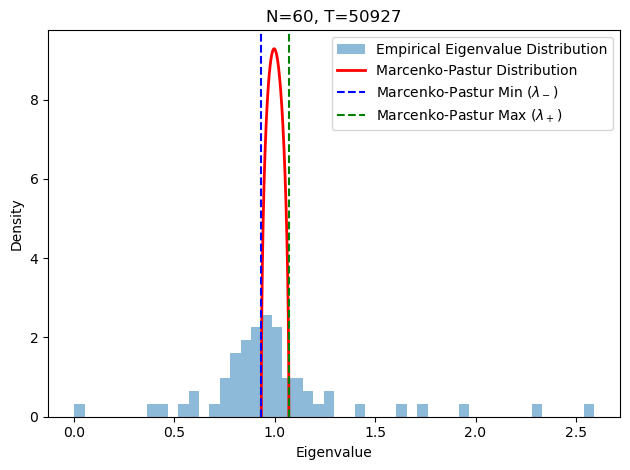

In [73]:

# Define the Marcenko-Pastur PDF function
def marcenko_pastur_pdf(lambda_val, q): #q = T / N
    lambda_min = (1 - np.sqrt(1 / q))**2
    lambda_max = (1 + np.sqrt(1 / q))**2
    if lambda_min <= lambda_val <= lambda_max:
        return (q / (2 * np.pi * lambda_val)) * np.sqrt((lambda_max - lambda_val) * (lambda_val - lambda_min))
    else:
        return 0

# Function to generate eigenvalue distribution and plot Marcenko-Pastur distribution for given N and T
def plot_marcenko_pastur(N, T, eigenvalues):

    # Marcenko-Pastur distribution parameters
    q = T / N
    lambda_min = (1 - np.sqrt(1 / q))**2
    lambda_max = (1 + np.sqrt(1 / q))**2

    print(f"Marcenko-Pastur Min: {lambda_min}, Max: {lambda_max}")

    # Generate Marcenko-Pastur distribution values for refined range
    lambda_values = np.linspace(lambda_min, lambda_max, 1000)
    marcenko_pastur_values = [marcenko_pastur_pdf(lmbd, q) for lmbd in lambda_values]
    
    # Plotting in the specified subplot
    plt.hist(eigenvalues, bins=50, density=True, alpha=0.5, label="Empirical Eigenvalue Distribution") #Denisty = true makes the histogram normalized to form a probability density instead of just raw counts
    plt.plot(lambda_values, marcenko_pastur_values, color='red', lw=2, label="Marcenko-Pastur Distribution")
    plt.axvline(lambda_min, color='blue', linestyle='--', label="Marcenko-Pastur Min ($\lambda_-$)")
    plt.axvline(lambda_max, color='green', linestyle='--', label="Marcenko-Pastur Max ($\lambda_+$)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.title(f"N={N}, T={T}")
    plt.legend()

# Plot settings for 3 subplots with adjusted third matrix size
#plt.figure(figsize=(18, 5))

#Remove largest eigenvalue from the eigenvalues list
# eigenvalues = copy.deepcopy(eigenvalues).tolist()  # Convert to list
# eigenvalues.remove(max(eigenvalues))  # Remove the maximum value

# First plot with N=100, T=500
plot_marcenko_pastur(N,T,eigenvalues)



# Show the combined plots
plt.tight_layout()
plt.show()

# A good observation:
---

The large market mode is due to the fact that most coins are so heavily affected by the same underlying factor, which is the movement of Bitcoin. It is exactly because there is such a strong common driver that spectral methods and graph‑based community detection tend to find just a handful of big clusters (e.g.\ BTC vs. Ethereum vs. Meme coins), rather than a huge number of niche groups.

In [13]:
# spectral_communities, company_communities_spectral, modularities = recursive_spectral_method(C_g,correlation_matrix, company_names,min_size=2, modularity_threshold=0.00001)

In [14]:
louvain_company_communities = map_communities_to_company_names(louvain_communities,company_names)

In [15]:

print("LOUVAIN COMPANY COMMUNITIES")
print("---------------------------")
for louvain_company_community in louvain_company_communities:
    print(louvain_company_community)

LOUVAIN COMPANY COMMUNITIES
---------------------------
['FETUSDT_2024_5m', 'FLOWUSDT_2024_5m', 'MANAUSDT_2024_5m', 'UNIUSDT_2024_5m', 'HBARUSDT_2024_5m', 'EGLDUSDT_2024_5m', 'GALAUSDT_2024_5m', 'JASMYUSDT_2024_5m', 'SANDUSDT_2024_5m', 'ICPUSDT_2024_5m', 'INJUSDT_2024_5m', 'FILUSDT_2024_5m', 'ENSUSDT_2024_5m', 'IOTAUSDT_2024_5m', 'APTUSDT_2024_5m', 'XTZUSDT_2024_5m', 'JTOUSDT_2024_5m', 'LINKUSDT_2024_5m', 'SEIUSDT_2024_5m', 'NEARUSDT_2024_5m', 'AVAXUSDT_2024_5m', 'GRTUSDT_2024_5m', 'AXSUSDT_2024_5m', 'THETAUSDT_2024_5m', 'ARBUSDT_2024_5m', 'LDOUSDT_2024_5m', 'ALGOUSDT_2024_5m', 'SUIUSDT_2024_5m', 'IMXUSDT_2024_5m', 'TIAUSDT_2024_5m', 'ATOMUSDT_2024_5m', 'CRVUSDT_2024_5m', 'SOLUSDT_2024_5m', 'EOSUSDT_2024_5m', 'OPUSDT_2024_5m', 'WLDUSDT_2024_5m', 'STXUSDT_2024_5m']
['SHIBUSDT_2024_5m', 'XLMUSDT_2024_5m', 'BONKUSDT_2024_5m', 'TRXUSDT_2024_5m', 'BTCUSDT_2024_5m', 'DOGEUSDT_2024_5m', 'BNBUSDT_2024_5m', 'ETHUSDT_2024_5m', 'QNTUSDT_2024_5m', 'NEOUSDT_2024_5m', 'ETCUSDT_2024_5m', 'PAXGUSDT_20

# Analysis
---
 * The groupings make sense overall: Community 1 consists of smaller, more speculative coins, while Community 2 includes larger, well-established cryptocurrencies and meme coins that have gained mainstream recognition.

* The fact that meme coins like DOGE, SHIB, and PEPE end up in Community 2 alongside large-cap coins is noteworthy, but still logical. Meme coins often follow the broader trends set by large-cap coins, especially BTC and ETH, as they are influenced by the overall market sentiment.

* I tried performing community detection again to obtain smaller sub communities, but could not find any meaningful structure within the communities (no eignevalues greater than lambda max aside from the market mode, which can be interpreted as the common community specific driving factor.) In practice, that’s exactly the signal you want: a principled stopping point telling you “this group is internally homogeneous once you account for its one common driver.”


# Community breakdown
---

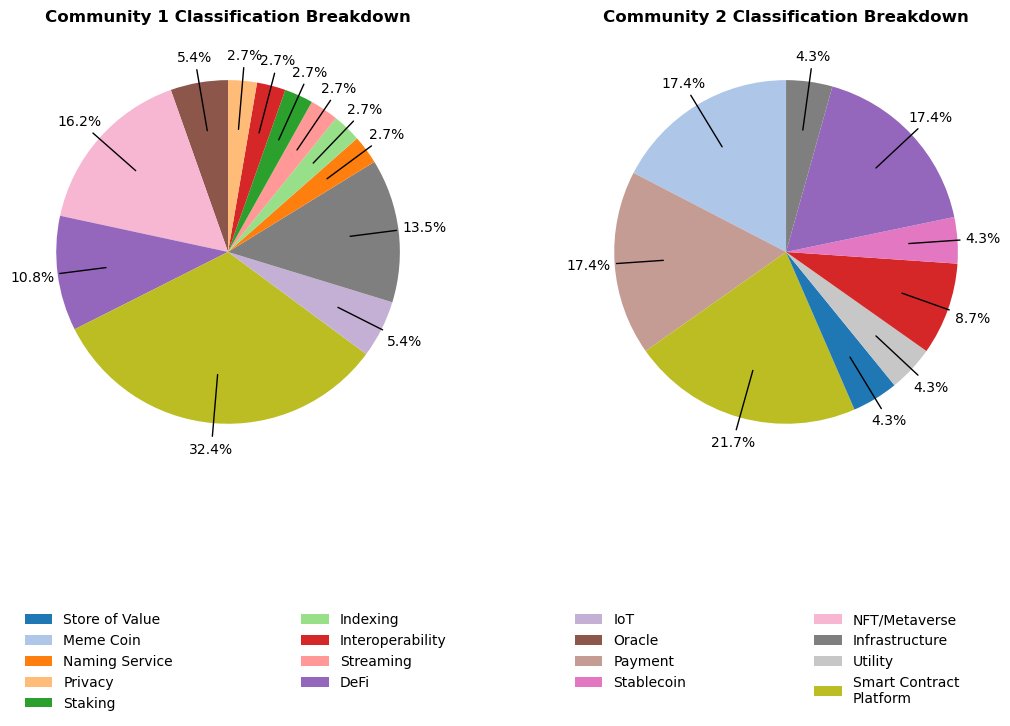

In [16]:
community1 = louvain_company_communities[0]
community2 = louvain_company_communities[1]


# Map each ticker to its classification
classification = {
    # Community 1
    'FETUSDT_2024_5m':    'Oracle',
    'UNIUSDT_2024_5m':    'DeFi',
    'APTUSDT_2024_5m':    'Smart Contract Platform',
    'LINKUSDT_2024_5m':   'Oracle',
    'THETAUSDT_2024_5m':  'Streaming',
    'LDOUSDT_2024_5m':    'Staking',
    'FLOWUSDT_2024_5m':   'NFT/Metaverse',
    'XTZUSDT_2024_5m':    'Smart Contract Platform',
    'ENSUSDT_2024_5m':    'Naming Service',
    'ARBUSDT_2024_5m':    'Infrastructure',
    'SUIUSDT_2024_5m':    'Smart Contract Platform',
    'SEIUSDT_2024_5m':    'DeFi',
    'GRTUSDT_2024_5m':    'Indexing',
    'WLDUSDT_2024_5m':    'Privacy',
    'IOTAUSDT_2024_5m':   'IoT',
    'OPUSDT_2024_5m':     'Infrastructure',
    'SANDUSDT_2024_5m':   'NFT/Metaverse',
    'ATOMUSDT_2024_5m':   'Interoperability',
    'INJUSDT_2024_5m':    'DeFi',
    'MANAUSDT_2024_5m':   'NFT/Metaverse',
    'SOLUSDT_2024_5m':    'Smart Contract Platform',
    'CRVUSDT_2024_5m':    'DeFi',
    'AVAXUSDT_2024_5m':   'Smart Contract Platform',
    'JTOUSDT_2024_5m':    'Infrastructure',
    'EOSUSDT_2024_5m':    'Smart Contract Platform',
    'AXSUSDT_2024_5m':    'NFT/Metaverse',
    'JASMYUSDT_2024_5m':  'IoT',
    'EGLDUSDT_2024_5m':   'Smart Contract Platform',
    'ICPUSDT_2024_5m':    'Smart Contract Platform',
    'GALAUSDT_2024_5m':   'NFT/Metaverse',
    'FILUSDT_2024_5m':    'Infrastructure',
    'ALGOUSDT_2024_5m':   'Smart Contract Platform',
    'TIAUSDT_2024_5m':    'Infrastructure',
    'IMXUSDT_2024_5m':    'NFT/Metaverse',
    'STXUSDT_2024_5m':    'Smart Contract Platform',
    'NEARUSDT_2024_5m':   'Smart Contract Platform',
    'HBARUSDT_2024_5m':   'Smart Contract Platform',

    # Community 2
    'NEXOUSDT_2024_5m':   'DeFi',
    'SHIBUSDT_2024_5m':   'Meme Coin',
    'XRPUSDT_2024_5m':    'Payment',
    'MKRUSDT_2024_5m':    'DeFi',
    'PAXGUSDT_2024_5m':   'Stablecoin',
    'PEPEUSDT_2024_5m':   'Meme Coin',
    'BONKUSDT_2024_5m':   'Meme Coin',
    'QNTUSDT_2024_5m':    'Interoperability',
    'DOTUSDT_2024_5m':    'Interoperability',
    'DOGEUSDT_2024_5m':   'Meme Coin',
    'LTCUSDT_2024_5m':    'Payment',
    'VETUSDT_2024_5m':    'Infrastructure',
    'TRXUSDT_2024_5m':    'Smart Contract Platform',
    'XLMUSDT_2024_5m':    'Payment',
    'BCHUSDT_2024_5m':    'Payment',
    'BNBUSDT_2024_5m':    'Utility',
    'ETCUSDT_2024_5m':    'Smart Contract Platform',
    'ETHUSDT_2024_5m':    'Smart Contract Platform',
    'DEXEUSDT_2024_5m':   'DeFi',
    'ADAUSDT_2024_5m':    'Smart Contract Platform',
    'NEOUSDT_2024_5m':    'Smart Contract Platform',
    'AAVEUSDT_2024_5m':   'DeFi',
    'BTCUSDT_2024_5m':    'Store of Value',
}

#Define a function to get the classification counts for a community
def classification_counts(community):
    counts = Counter(classification.get(asset, 'Unknown') for asset in community)
    labels = list(counts.keys()) #A set of distinct  classification names (e.g. ['Smart Contract Platform', 'DeFi', 'Payment', …]).
    sizes = list(counts.values()) # The corresponding list of counts for each label (e.g. [15, 12, 5, …]).
    return labels, sizes


def classification_counts(community):
    counts = Counter(classification.get(asset, 'Unknown') for asset in community)
    labels = list(counts.keys())
    sizes = list(counts.values())
    return labels, sizes

# Compute labels and sizes
labels1, sizes1 = classification_counts(community1)
labels2, sizes2 = classification_counts(community2)

# Create a consistent color map
unique_labels = list(set(labels1) | set(labels2))
cmap = plt.get_cmap('tab20')
color_map = {lbl: cmap(i) for i, lbl in enumerate(unique_labels)}
colors1 = [color_map[lbl] for lbl in labels1]
colors2 = [color_map[lbl] for lbl in labels2]

# Build the figure and axes for two pies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Community 1
wedges1, _ = ax1.pie(sizes1, colors=colors1, startangle=90, labels=None)
ax1.set_title('Community 1 Classification Breakdown', pad=30, fontweight='bold')
ax1.axis('equal')
total1 = sum(sizes1)
for i, w in enumerate(wedges1):
    ang = (w.theta2 + w.theta1) / 2
    x, y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
    ax1.annotate(f"{sizes1[i]/total1*100:.1f}%", xy=(0.7*x,0.7*y),
                 xytext=(1.15*x,1.15*y), arrowprops=dict(arrowstyle='-'),
                 ha='center', va='center')

# Community 2
wedges2, _ = ax2.pie(sizes2, colors=colors2, startangle=90, labels=None)
ax2.set_title('Community 2 Classification Breakdown', pad=30, fontweight='bold')
ax2.axis('equal')
total2 = sum(sizes2)
for i, w in enumerate(wedges2):
    ang = (w.theta2 + w.theta1) / 2
    x, y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
    ax2.annotate(f"{sizes2[i]/total2*100:.1f}%", xy=(0.7*x,0.7*y),
                 xytext=(1.15*x,1.15*y), arrowprops=dict(arrowstyle='-'),
                 ha='center', va='center')

# Legend with wrapped labels
wrapped = {lbl: '\n'.join(textwrap.wrap(lbl,20)) for lbl in unique_labels}
handles = [Patch(facecolor=color_map[lbl], label=wrapped[lbl]) for lbl in unique_labels]
w = 0.8
fig.legend(
    handles=handles,
    loc='lower left',  # this means “place the legend box’s lower‑left at the bbox anchor”
    bbox_to_anchor=( (1-w)/2, -0.25, w, 0.15 ),
    mode='expand',
    ncol=4,
    frameon=False,
    columnspacing=1.2,
    labelspacing=0.5
)

# Spacing adjustments
fig.subplots_adjust(top=0.85, # how close the pies go to the top of the figure
                    bottom=0.22, # how high above the bottom (where the legend lives)
                    wspace=0.5)  # horizontal space between the two pies





# Description of categories
---

- **Oracle**  
  Decentralized services that securely fetch and relay real‑world data (e.g.\ price feeds, weather, sports scores) into smart contracts on‑chain.

- **DeFi**  
  “Decentralized Finance” protocols enabling lending, borrowing, trading, yield farming, liquidity provision, and other financial services without traditional intermediaries.

- **Smart Contract Platform**  
  Layer‑1 blockchains (or closely integrated ecosystems) designed to run fully general programmable contracts and decentralized applications.

- **Streaming**  
  Peer‑to‑peer networks for decentralized video or media streaming—rewarding participants for sharing and relaying live or on‑demand content.

- **Staking**  
  Tokens whose primary purpose is to be locked up (“staked”) to secure proof‑of‑stake networks, often earning rewards or governance rights in return.

- **NFT/Metaverse**  
  Platforms and tokens that power non‑fungible token marketplaces, digital collectibles, gaming worlds, and immersive virtual environments.

- **Naming Service**  
  Decentralized domain or identity systems (e.g.\ ENS) that map human‑readable names to on‑chain addresses and metadata.

- **Infrastructure**  
  Protocols offering foundational services—storage (e.g.\ Filecoin), middleware, sidechains, or other tooling—that underpin blockchain applications.

- **Indexing**  
  Services (like The Graph) that crawl, organize, and index blockchain data so that dApps can query it efficiently via GraphQL or APIs.

- **Privacy**  
  Coins and protocols engineered to obfuscate transaction details (amounts, counterparties) and provide stronger on‑chain confidentiality.

- **IoT**  
  Ledger systems tailored for the Internet of Things—enabling secure machine‑to‑machine data exchange, micropayments, and device identity.

- **Interoperability**  
  Bridges, relays, or cross‑chain frameworks that let tokens and data flow seamlessly between different blockchains.

- **Meme Coin**  
  Community‑driven tokens launched with a humorous or viral theme, often with no fundamental utility beyond social engagement and trading.

- **Payment**  
  Cryptocurrencies designed primarily for fast, low‑cost peer‑to‑peer value transfer and remittance.

- **Stablecoin**  
  Tokens pegged to a stable asset (e.g., USD, EUR, gold), maintaining a fixed value to reduce volatility in crypto transactions.

- **Utility**  
  Protocol tokens used to pay for network services (gas fees), grant access to features, or incentivize specific behaviors within an ecosystem.

- **Store of Value**  
  Digital assets (like Bitcoin) intended chiefly as a long‑term value reserve—analogous to “digital gold” rather than for daily transactions.


# Save communities
---

In [17]:
#Create a dataframe with the community names and their corresponding tickers

community_df = pd.DataFrame({
    'Community': ['Community 1'] * len(community1) + ['Community 2'] * len(community2),
    'Ticker': community1 + community2
})

#Save the communities dataframe to a csv file
community_df.to_csv('results/community_detection/communities_2024.csv', index=False)


#Check the dataframe

# print("Community 1")
# print("---------------------")

# community_df_community1 = community_df[community_df['Community'] == 'Community 1']
# community_df_community1 = list(community_df_community1['Ticker'])
# print(community_df_community1)
# print(community1)

# print("Community 2")
# print("---------------------")

# community_df_community2 = community_df[community_df['Community'] == 'Community 2']
# community_df_community2 = list(community_df_community2['Ticker'])
# print(community_df_community2)
# print(community2)

In [18]:
community_df

,Community,Ticker
0,Community 1,FETUSDT_2024_5m
1,Community 1,FLOWUSDT_2024_5m
2,Community 1,MANAUSDT_2024_5m
3,Community 1,UNIUSDT_2024_5m
4,Community 1,HBARUSDT_2024_5m
5,Community 1,EGLDUSDT_2024_5m
6,Community 1,GALAUSDT_2024_5m
7,Community 1,JASMYUSDT_2024_5m
8,Community 1,SANDUSDT_2024_5m
9,Community 1,ICPUSDT_2024_5m


# Round 2 of community detection 
---

In [19]:
# #Create filtered dataframes

# filtered_dfs = []
# for i, louvain_company_community in enumerate(louvain_company_communities):
#     filtered_df = merged_df_standardized_log_returns[louvain_company_community]
#     filtered_dfs.append(filtered_df)
#     print(f"Filtered DataFrame {i+1} shape: {filtered_df.shape}")
#     print(f"Filtered DataFrame {i+1} columns: {filtered_df.columns.tolist()}")
#     print()

In [20]:
# filtered_dfs[1]

In [21]:

# correlation_matrix,T,N,company_names = create_correlation_matrix(filtered_dfs[1]) 
# C_g = calculate_C_g(correlation_matrix,T,N) #Modularity matrix
# print(correlation_matrix.shape)
# correlation_matrix_np = np.array(correlation_matrix)
# louvain_communities = modified_louvain(C_g,correlation_matrix_np)

# print("Global modularity of modified Louvain method: ", calculate_global_modularity(louvain_communities, C_g, correlation_matrix_np))


In [22]:
# #Print elemnts of C_g

# for i in range(len(C_g)):
#     print(f"Row {i}:")
#     for j in range(len(C_g[i])):
#         print(f"C_g[{i}][{j}] = {C_g[i][j]}")

In [23]:
# N

In [24]:
# louvain_company_communities = map_communities_to_company_names(louvain_communities,company_names)

In [25]:

# print("LOUVAIN COMPANY COMMUNITIES 2")
# print("---------------------------")
# for louvain_company_community in louvain_company_communities:
#     print(louvain_company_community)

# Round 3 of community detection 
---

In [26]:
# # Next round of community detection 

# #Create filtered dataframes

# filtered_dfs = []
# for i, louvain_company_community in enumerate(louvain_company_communities):
#     filtered_df = merged_df_standardized_log_returns[louvain_company_community]
#     filtered_dfs.append(filtered_df)
#     print(f"Filtered DataFrame {i+1} shape: {filtered_df.shape}")
#     print(f"Filtered DataFrame {i+1} columns: {filtered_df.columns.tolist()}")
#     print()


In [27]:
# correlation_matrix,T,N,company_names = create_correlation_matrix(filtered_dfs[0]) 
# C_g = calculate_C_g(correlation_matrix,T,N) #Modularity matrix
# print(correlation_matrix.shape)
# correlation_matrix_np = np.array(correlation_matrix)
# louvain_communities = modified_louvain(C_g,correlation_matrix_np)

# print("Global modularity of modified Louvain method: ", calculate_global_modularity(louvain_communities, C_g, correlation_matrix_np))
